In [15]:
from ml_logic.preprocessing import preprocessing_24_hour
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.stats import loguniform
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from random import uniform
import xgboost
from sklearn.ensemble import AdaBoostClassifier


In [2]:
data = pd.read_csv('/Users/franciscochaves/code/DomNau1001/Risk_ICU/raw_data/training_v2.csv')

In [3]:
X, y = preprocessing_24_hour(data)

/Users/franciscochaves/code/DomNau1001/Risk_ICU/ml_logic/preprocessing.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_post_cats[ohe.get_feature_names_out()] = ohe.transform(X_post_cats[["ethnicity"]])
/Users/franciscochaves/code/DomNau1001/Risk_ICU/ml_logic/preprocessing.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_post_cats[ohe.get_feature_names_out()] = ohe.transform(X_post_cats[["ethnicity"]])
/Users/franciscochaves/code/DomNau1001/Risk_ICU/ml_logic/preprocessing.py:69: SettingWithCopyW

In [4]:
X.shape, y.shape

((73542, 49), (73542, 1))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [7]:
# smote = SMOTE(random_state=42)

# X_res, y_res = smote.fit_resample(X_train, y_train)

In [7]:
# Initialize the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the training data
X_res, y_res = oversampler.fit_resample(X_train, y_train)

In [8]:
y_res.value_counts()

0
0    37145
1    37145
Name: count, dtype: int64

### NB

In [10]:
nb = GaussianNB()
nb.fit(X_res, y_res)

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [11]:
from sklearn.ensemble import AdaBoostClassifier

ada_nb = AdaBoostClassifier(nb, n_estimators=50)
ada_nb.fit(X_res, y_res)

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=GaussianNB())

In [12]:
predictions = ada_nb.predict(X_test)
recall_nb = recall_score(y_test, predictions)
recall_nb

0.7087378640776699

In [13]:
y_score = ada_nb.predict_proba(X_test)[:, 1]
y_true = y_test
auc_score = roc_auc_score(y_true, y_score)
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.6295514326138321


/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/

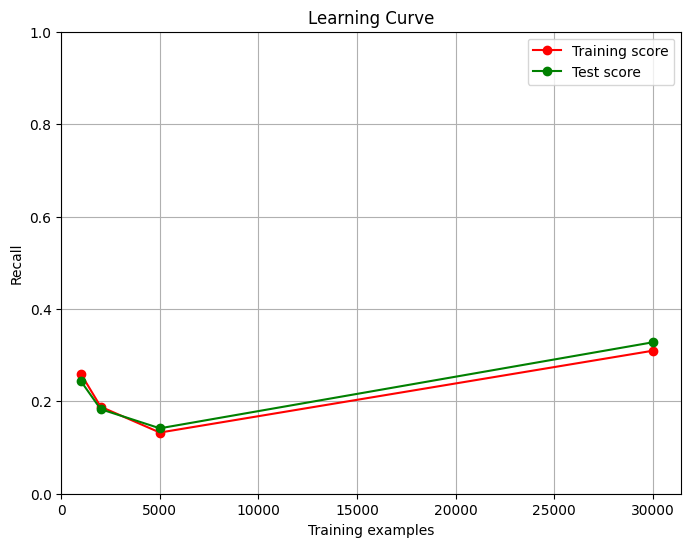

In [26]:
plot_learning_curve(ada_nb, X, y, train_sizes)

In [14]:



param_grid = {
    'var_smoothing': loguniform(1e-9, 1e-6),
}

random_search = RandomizedSearchCV(estimator=nb, param_distributions=param_grid,
                                   n_iter=50, cv=5, scoring='recall', n_jobs=-1, random_state=42)

random_search.fit(X_res, y_res)
best_nb_model = random_search.best_estimator_
y_pred = best_nb_model.predict(X_test)
recall_nb = recall_score(y_test, y_pred)
recall_nb


/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/

0.6065649560795192

In [15]:
ada_nb = AdaBoostClassifier(best_nb_model, n_estimators=50)
ada_nb.fit(X_res, y_res)

predictions = ada_nb.predict(X_test)
recall_nb = recall_score(y_test, predictions)
recall_nb

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.39158576051779936

In [16]:
y_score = ada_nb.predict_proba(X_test)[:, 1]
y_true = y_test
auc_score = roc_auc_score(y_true, y_score)
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.5399760592142404


# NB recall=91% AUC=0.46

# Decision Tree

In [16]:
tree = DecisionTreeClassifier(class_weight = "balanced", min_samples_split=12, min_samples_leaf=6, max_leaf_nodes=45, max_features=None, max_depth = 2, criterion = "entropy", splitter = "random", min_impurity_decrease=0.0)
tree.fit(X_res, y_res)

ada_tree = AdaBoostClassifier(tree, n_estimators=100, learning_rate = 0.2, algorithm = "SAMME.R",random_state=42)
ada_tree.fit(X_res, y_res)

predictions = ada_tree.predict(X_test)
recall_dt = recall_score(y_test, predictions, average='binary')
recall_dt

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.7461858529819695

In [17]:
y_score = ada_tree.predict_proba(X_test)[:, 1]
y_true = y_test
auc_score = roc_auc_score(y_true, y_score)
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.8522801246175398


/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-pac

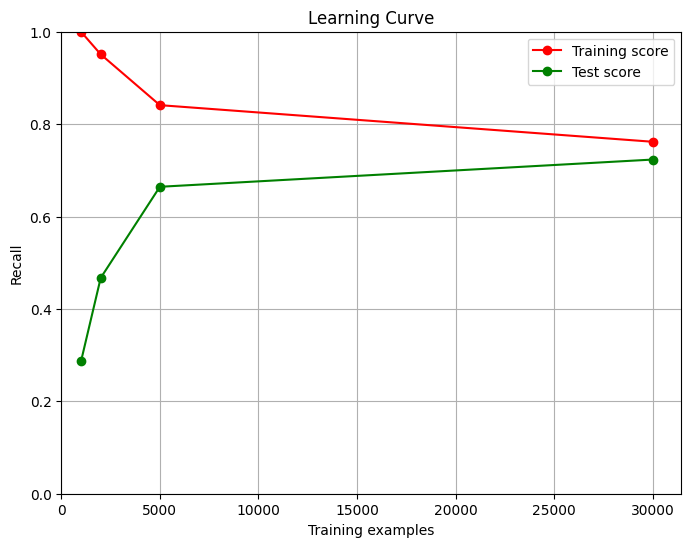

In [18]:
plot_learning_curve(ada_tree, X, y, train_sizes)

# Trees recall=70% AUC=0.82

# XGBOOST

In [9]:


xgb_model = xgboost.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    reg_alpha=0.5,
    max_depth=3,
    learning_rate=0.1
)

xgb_model.fit(X_res, y_res)
y_pred = xgb_model.predict(X_test)
recal_xgb = recall_score(y_test, y_pred)
recal_xgb = round(recal_xgb, 2)
recal_xgb

0.74

In [10]:
y_score = xgb_model.predict_proba(X_test)[:, 1]
y_true = y_test
auc_score = roc_auc_score(y_true, y_score)
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.8535977158097469


/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/si

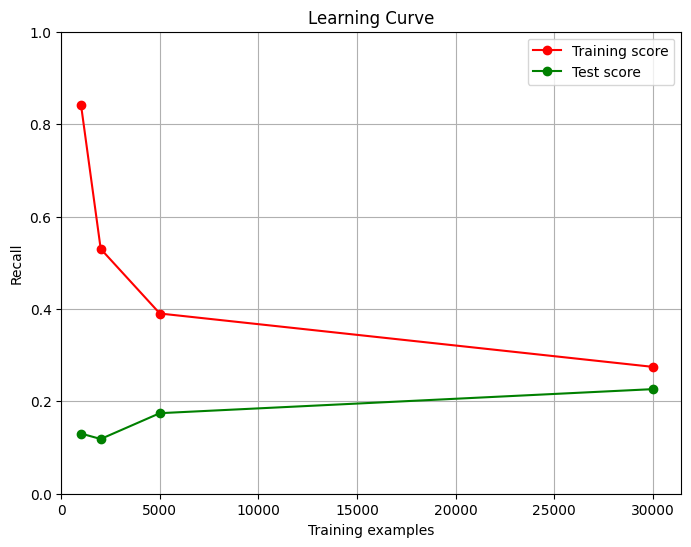

In [13]:
plot_learning_curve(xgb_model, X, y, train_sizes)

# XGB recall=74% AUC=0.85

# SVC

In [30]:
svc = SVC(kernel = "sigmoid", C = 9.18, coef0=0.14, gamma = "scale", probability = True, class_weight="balanced")
svc.fit(X_res, y_res)
predictions = svc.predict(X_test)
recall_svc = recall_score(y_test, predictions, average='binary')
recall_svc

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.608876560332871

In [32]:
y_score = svc.predict_proba(X_test)[:, 1]
y_true = y_test
auc_score = roc_auc_score(y_true, y_score)
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.6473321182890875


In [33]:
plot_learning_curve(svc, X, y, train_sizes)

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/

KeyboardInterrupt: 

In [ ]:
# ada_svc = AdaBoostClassifier(svc, n_estimators=50)

# ada_svc.fit(X_res, y_res)

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
# predictions = ada_svc.predict(X_test)
# recall_svc = recall_score(y_test, predictions, average='binary')
# recall_svc

In [ ]:
# y_score = ada_svc.predict_proba(X_test)[:, 1]
# y_true = y_test
# auc_score = roc_auc_score(y_true, y_score)
# print("ROC AUC Score:", auc_score)

In [12]:
def plot_learning_curve(estimator, X, y, train_sizes, scoring='recall'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=5, scoring=scoring, n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")
    plt.xlabel("Training examples")
    plt.ylabel("Recall")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.xlim(left=0)
    plt.ylim(bottom=0, top=1.0)
    plt.grid(True)
    plt.show()

train_sizes = [100, 500, 1000, 2000, 5000, 30000]

# Ensemble Model

In [20]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# classifier1 = ada_nb
# classifier2 = ada_tree
# classifier3 = xgb_model
# classifier4 = svc

classifier1 = ada_tree
classifier2 = xgb_model

In [21]:
voting_classifier = VotingClassifier(
    estimators=[('tree', classifier1), ('xgb', classifier2)],
    voting='hard'
)

voting_classifier.fit(X_res, y_res)
predictions = voting_classifier.predict(X_test)

recall_hard = recall_score(y_test, predictions, average='binary')
recall_hard

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.7087378640776699

In [25]:
voting_classifier = VotingClassifier(
    estimators=[('tree', classifier1), ('xgb', classifier2)],
    voting='soft'
)

voting_classifier.fit(X_res, y_res)
predictions = voting_classifier.predict(X_test)

recall_soft = recall_score(y_test, predictions, average='binary')
recall_soft

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.7406380027739251

In [30]:
y_score = voting_classifier.predict_proba(X_test)[:, 1]
y_true = y_test
auc_score = roc_auc_score(y_true, y_score)
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.8540998798895075


In [53]:
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

stacking_classifier = StackingClassifier(
    estimators=[('tree', classifier1), ('xgb', classifier2)],
    final_estimator=LogisticRegression()
)

# Train the stacking classifier
stacking_classifier.fit(X_res, y_res)

# Make predictions
predictions = stacking_classifier.predict(X_test)

# Calculate recall
recall = recall_score(y_test, predictions)
recall

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/

0.742949607027277

In [54]:
y_score = stacking_classifier.predict_proba(X_test)[:, 1]
y_true = y_test
auc_score = roc_auc_score(y_true, y_score)
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.8540290216686763


In [61]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform, randint
from sklearn.metrics import recall_score

# Define base classifiers
estimators = [LogisticRegression(), GradientBoostingClassifier(), AdaBoostClassifier(), XGBClassifier(), MLPClassifier()]

# Define parameter grid for each classifier
param_grid = {
    'logistic_regression': {
        'C': uniform(0.1, 10)  # Regularization parameter for Logistic Regression
    },
    'gradient_boosting': {
        'n_estimators': randint(50, 200),  # Number of boosting stages
        'learning_rate': uniform(0.01, 0.1),  # Learning rate
        'max_depth': randint(3, 10)  # Maximum depth of the individual trees
    },
    'adaboost': {
        'n_estimators': randint(50, 200),  # Number of weak learners
        'learning_rate': uniform(0.01, 0.1)  # Learning rate
    },
    'xgboost': {
        'n_estimators': randint(50, 200),  # Number of boosting rounds
        'learning_rate': uniform(0.01, 0.1),  # Learning rate
        'max_depth': randint(3, 10)  # Maximum depth of a tree
    },
    'mlp': {
        'hidden_layer_sizes': [(100,), (50, 100), (50, 50, 50)],  # Size of hidden layers
        'activation': ['logistic', 'tanh', 'relu'],  # Activation function
        'alpha': uniform(0.0001, 0.001)  # L2 penalty (regularization term) parameter
    }
}

scores = []

# Define StackingClassifier
for estimator in estimators:
    stacking_classifier = StackingClassifier(estimators=[('tree', classifier1), ('xgb', classifier2)],
    final_estimator=estimator)
    stacking_classifier.fit(X_res, y_res)
    predictions = stacking_classifier.predict(X_test)
    recall = recall_score(y_test, predictions)
    scores.append(recall)
scores


/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/

[0.742949607027277,
 0.7475728155339806,
 0.7461858529819695,
 0.7466481738326398,
 0.7605177993527508]

In [68]:
stacking_classifier = StackingClassifier(
    estimators=[('tree', classifier1), ('xgb', classifier2)],
    final_estimator=MLPClassifier(hidden_layer_sizes=50, activation='logistic', learning_rate='adaptive', solver='adam', batch_size=64)
)

# Train the stacking classifier
stacking_classifier.fit(X_res, y_res)

# Make predictions
predictions = stacking_classifier.predict(X_test)

# Calculate recall
recall = recall_score(y_test, predictions)
recall

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/

0.7577438742487286

In [69]:
mlp_classifier = MLPClassifier()

# Define parameter grid for MLPClassifier
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 100, 50)],  # Size of hidden layers
    'activation': ['logistic', 'tanh', 'relu'],  # Activation function
    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization term) parameter
    'learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
    'max_iter': [100, 200, 300],  # Maximum number of iterations
    'solver': ['adam', 'sgd', 'lbfgs'],  # Solver for weight optimization
    'batch_size': [32, 64, 128]  # Size of minibatches for stochastic optimizers
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(mlp_classifier, param_distributions=param_grid_mlp, n_iter=100, cv=5, scoring='recall', random_state=42)
random_search.fit(X_res, y_res)

# Best parameters and score
print("Best parameters for MLPClassifier:", random_search.best_params_)
print("Best score for MLPClassifier:", random_search.best_score_)

# Make predictions
predictions = random_search.predict(X_test)

# Calculate recall
recall = recall_score(y_test, predictions)
print("Recall:", recall)

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_

In [36]:
voting_classifier = VotingClassifier(
    estimators=[('nb', classifier1), ('tree', classifier2), ('xgb', classifier3), ('svc', classifier4)],
    voting='hard'
)

voting_classifier.fit(X_res, y_res)
predictions = voting_classifier.predict(X_test)

recall_hard = recall_score(y_test, predictions, average='binary')
recall_hard

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/

0.5839112343966713

In [37]:
voting_classifier = VotingClassifier(
    estimators=[('nb', classifier1), ('tree', classifier2), ('xgb', classifier3), ('svc', classifier4)],
    voting='soft'
)

voting_classifier.fit(X_res, y_res)
predictions = voting_classifier.predict(X_test)

recall_soft = recall_score(y_test, predictions, average='binary')
recall_soft

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/

0.6846971798428109

In [38]:
from sklearn.metrics import roc_auc_score
y_score = voting_classifier.predict_proba(X_test)[:, 1]
y_true = y_test
auc_score = roc_auc_score(y_true, y_score)
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.7827787341701573


In [39]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_classifier = StackingClassifier(
    estimators=[('nb', classifier1), ('tree', classifier2), ('xgb', classifier3), ('svc', classifier4)],
    final_estimator=LogisticRegression()
)

# Train the stacking classifier
stacking_classifier.fit(X_res, y_res)

# Make predictions
predictions = stacking_classifier.predict(X_test)

# Calculate recall
recall = recall_score(y_test, predictions)
recall

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/

0.7438742487286176

In [ ]:
from sklearn.metrics import roc_auc_score
y_score = stacking_classifier.predict_proba(X_test)[:, 1]
y_true = y_test
auc_score = roc_auc_score(y_true, y_score)
print("ROC AUC Score:", auc_score)

In [40]:
voting_classifier = VotingClassifier(
    estimators=[('tree', classifier2), ('xgb', classifier3), ('svc', classifier4)],
    voting='soft'
)

voting_classifier.fit(X_res, y_res)
predictions = voting_classifier.predict(X_test)

recall_soft = recall_score(y_test, predictions, average='binary')
recall_soft

/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/franciscochaves/.pyenv/versions/3.10.6/envs/Risk_ICU/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


: 

: 

In [ ]:
stacking_classifier = StackingClassifier(
    estimators=[('tree', classifier2), ('xgb', classifier3), ('svc', classifier4)],
    final_estimator=LogisticRegression()
)

# Train the stacking classifier
stacking_classifier.fit(X_res, y_res)

# Make predictions
predictions = stacking_classifier.predict(X_test)

# Calculate recall
recall = recall_score(y_test, predictions)
recall